In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import holidays

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Data preprocessing

In [36]:
df =  pd.read_csv('2yrs_data.csv')

In [37]:
data = df.copy()
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
#data.set_index('Datetime', inplace=True)

# # Resample data to hourly frequency and compute the sum
# hourly_data = df['Global_active_power'].resample('H').sum().reset_index()
# hourly_data.rename(columns={'Global_active_power': 'Hourly_Sum'}, inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(hourly_data['Hourly_Sum'].values.reshape(-1, 1))

df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')
df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])


/var/folders/hb/pn_3c51d1fj1n2jntgjrxmpm0000gn/T/ipykernel_10846/128374963.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)


In [38]:
df

,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power
0,1,0,17,16,12,2006,1.473913
1,1,0,18,16,12,2006,2.611597
2,1,0,19,16,12,2006,2.371349
3,1,0,20,16,12,2006,2.234981
4,1,0,21,16,12,2006,2.015309
...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115323
17845,0,0,20,31,12,2008,3.177884
17846,0,0,21,31,12,2008,0.947328
17847,0,0,22,31,12,2008,-0.066589


In [39]:
df['hourly_active_power'].describe()

count    1.784900e+04
mean    -5.413962e-17
std      1.000028e+00
min     -1.078503e+00
25%     -8.280364e-01
50%     -3.405663e-01
75%      5.342907e-01
max      5.644476e+00
Name: hourly_active_power, dtype: float64

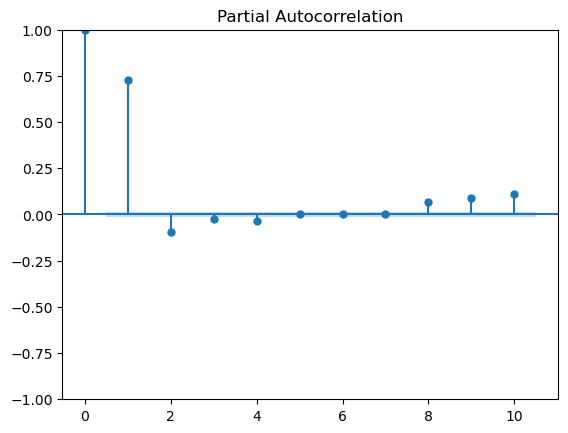

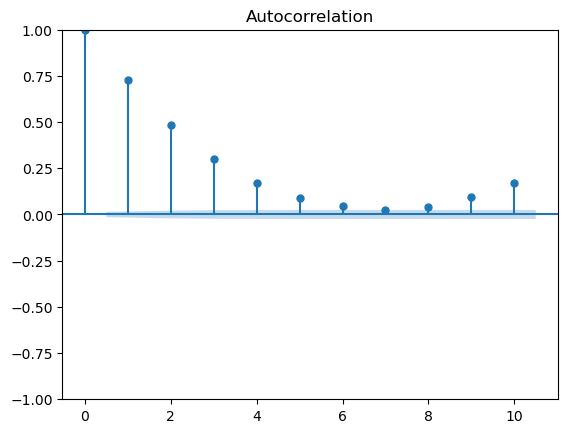

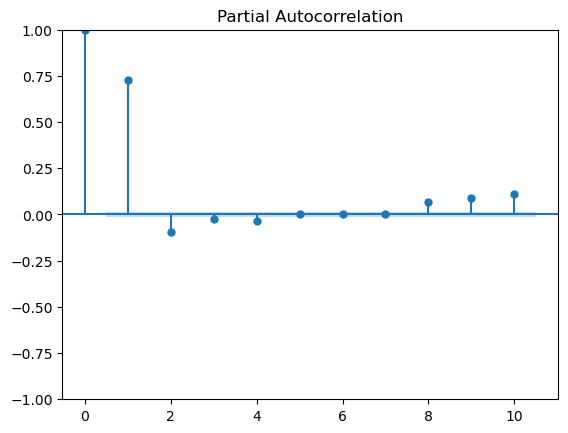

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['hourly_active_power'], lags=10)
plot_pacf(df['hourly_active_power'], lags=10)

# Baseline

In [ ]:
# Parameters
N_STEPS_IN = 2
N_STEPS_OUT = 5
N_EPOCHS = 20
BATCH_SIZE = 16

train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

train_values = train['hourly_active_power'].values 
X_train, y_train = create_sequences(train_values, N_STEPS_IN, N_STEPS_OUT)

test_values = test['hourly_active_power'].values
X_test, y_test = create_sequences(test_values, N_STEPS_IN, N_STEPS_OUT)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14273, 2, 1)
y_train shape: (14273, 5)
X_test shape: (3564, 2, 1)
y_test shape: (3564, 5)


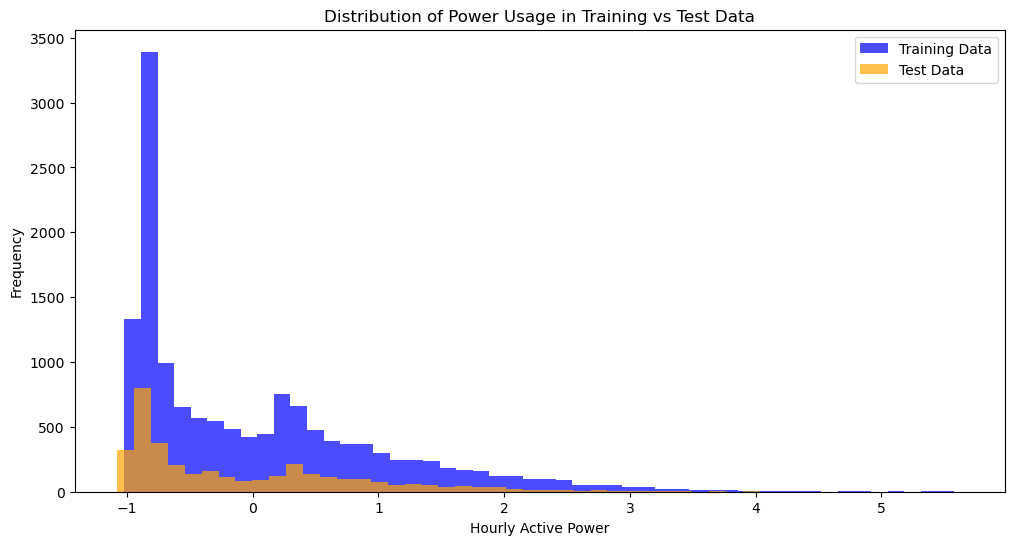

In [42]:
plt.figure(figsize=(12, 6))
plt.hist(train['hourly_active_power'], bins=50, alpha=0.7, label='Training Data', color='blue')
plt.hist(test['hourly_active_power'], bins=50, alpha=0.7, label='Test Data', color='orange')
plt.title('Distribution of Power Usage in Training vs Test Data')
plt.xlabel('Hourly Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.1),
    Dense(N_STEPS_OUT)
])

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

test_predictions = model.predict(X_test, verbose=0)

test_predictions = np.squeeze(test_predictions) 
y_test = np.squeeze(y_test)

print(f"Shape of predictions: {test_predictions.shape}")
print(f"Shape of test labels: {y_test.shape}")

test_mse = mean_squared_error(y_test, test_predictions)
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step - loss: 1.2304 - mae: 0.8846 - learning_rate: 1.0000e-04
Epoch 2/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 1.1344 - mae: 0.8401 - learning_rate: 1.0000e-04
Epoch 3/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 1.0439 - mae: 0.7937 - learning_rate: 1.0000e-04
Epoch 4/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 1.0116 - mae: 0.7793 - learning_rate: 1.0000e-04
Epoch 5/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 1.0041 - mae: 0.7745 - learning_rate: 1.0000e-04
Epoch 6/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 0.9944 - mae: 0.7698 - learning_rate: 1.0000e-04
Epoch 7/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - loss: 0.9899 - mae: 0.7683 - learning_rate: 1.0000e-04
Epoch 8/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.9864 - mae: 0.7653 - learning_rate: 1.0000e-04
Epoch 9/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 0.9848 - mae: 0.7639 - learning_rate: 1.0000e-04
Epoch 10/20


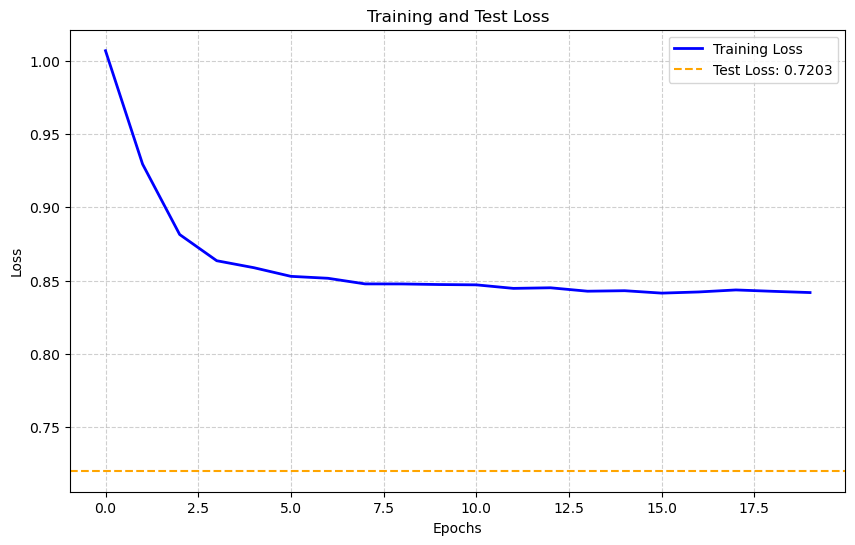

In [ ]:
loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

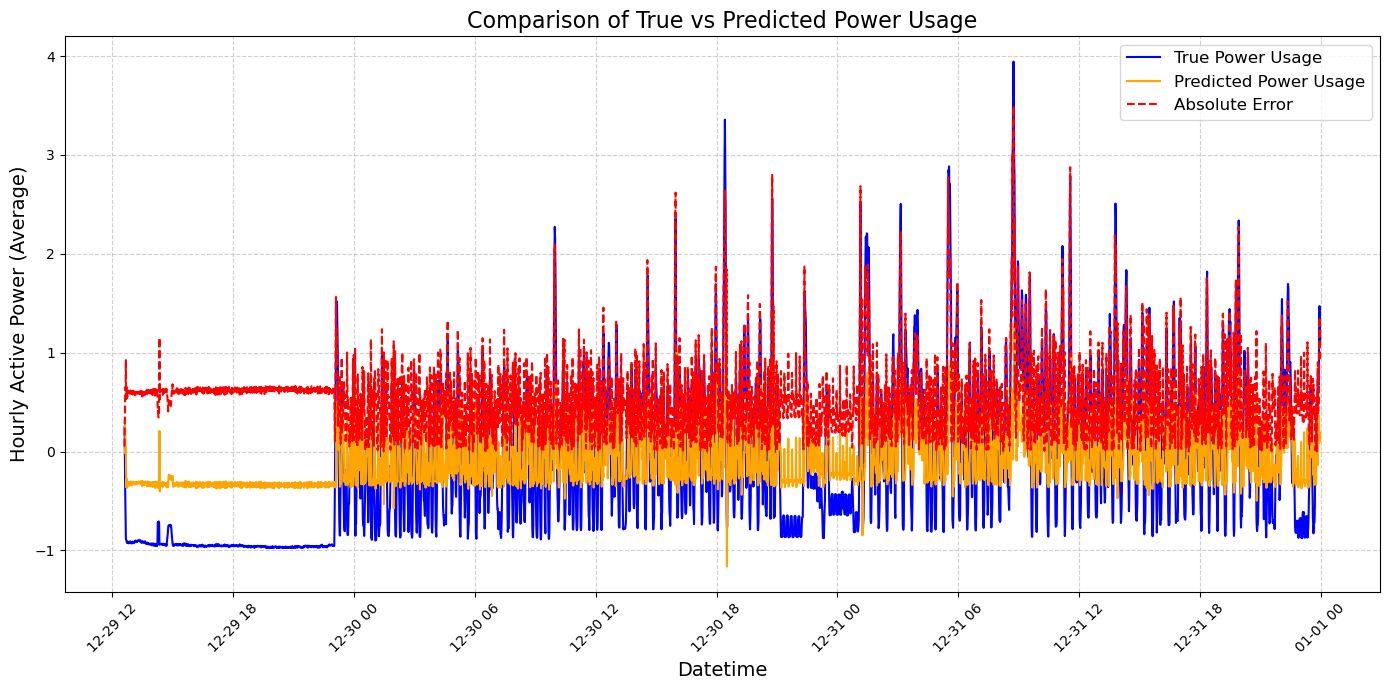

In [ ]:
y_pred_test = model.predict(X_test, verbose=0).squeeze() 

datetime_test = np.array(data['Datetime'][-len(y_test):]) 
y_test = y_test.squeeze()
y_pred_test = y_pred_test.squeeze() 

y_test_df = pd.DataFrame(y_test, columns=[f'True_{i}' for i in range(5)])
y_pred_test_df = pd.DataFrame(y_pred_test, columns=[f'Predicted_{i}' for i in range(5)])

y_test_df['True_Avg'] = y_test_df.mean(axis=1) 
y_pred_test_df['Predicted_Avg'] = y_pred_test_df.mean(axis=1) 

datetime_test = np.array(data['Datetime'][-len(y_test):]) 

results = pd.DataFrame({
    'Datetime': datetime_test,  
    'True_Avg': y_test_df['True_Avg'], 
    'Predicted_Avg': y_pred_test_df['Predicted_Avg'] 
})

results['Absolute_Error'] = np.abs(results['True_Avg'] - results['Predicted_Avg'])

plt.figure(figsize=(14, 7))
plt.plot(results['Datetime'], results['True_Avg'], label='True Power Usage', color='blue', linewidth=1.5)
plt.plot(results['Datetime'], results['Predicted_Avg'], label='Predicted Power Usage', color='orange', linewidth=1.5)
plt.plot(results['Datetime'], results['Absolute_Error'], label='Absolute Error', color='red', linestyle='--', linewidth=1.5)

plt.legend(fontsize=12, loc='upper right')
plt.title('Comparison of True vs Predicted Power Usage', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power (Average)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
print(f"Min prediction: {y_pred_test.min()}")
print(f"Max prediction: {y_pred_test.max()}")
print(f"Mean prediction: {y_pred_test.mean()}")

Min prediction: -1.7704969644546509
Max prediction: 2.608870506286621
Mean prediction: -0.07273618131875992


# Added Features

In [ ]:
train_size = int(len(df) * 0.8) 
train = df.iloc[:train_size]
test = df.iloc[train_size:]

def create_sequences(data, target_column, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data.iloc[i:i + n_steps_in].values)
        y.append(data[target_column].iloc[i + n_steps_in:i + n_steps_in + n_steps_out].values)
    return np.array(X), np.array(y)

features = ['is_weekend', 'is_holiday', 'hourly_active_power']
target = 'hourly_active_power'

X_train, y_train = create_sequences(train[features], target, N_STEPS_IN, N_STEPS_OUT)
X_test, y_test = create_sequences(test[features], target, N_STEPS_IN, N_STEPS_OUT)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14273, 2, 3)
y_train shape: (14273, 5)
X_test shape: (3564, 2, 3)
y_test shape: (3564, 5)


# Model fitting and training

In [ ]:
num_features = X_train.shape[2] 

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, num_features)),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.1),
    Dense(N_STEPS_OUT)
])

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.squeeze(test_predictions)  
y_test = np.squeeze(y_test) 

print(f"Shape of predictions: {test_predictions.shape}")
print(f"Shape of test labels: {y_test.shape}")

test_mse = mean_squared_error(y_test, test_predictions)
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - loss: 1.2303 - mae: 0.8842 - learning_rate: 1.0000e-04
Epoch 2/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 1.1353 - mae: 0.8354 - learning_rate: 1.0000e-04
Epoch 3/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 1.0318 - mae: 0.7897 - learning_rate: 1.0000e-04
Epoch 4/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 1.0015 - mae: 0.7761 - learning_rate: 1.0000e-04
Epoch 5/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 0.9859 - mae: 0.7694 - learning_rate: 1.0000e-04
Epoch 6/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.9799 - mae: 0.7653 - learning_rate: 1.0000e-04
Epoch 7/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.9731 - mae: 0.7616 - learning_rate: 1.0000e-04
Epoch 8/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.9668 - mae: 0.7584 - learning_rate: 1.0000e-04
Epoch 9/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 0.9652 - mae: 0.7573 - learning_rate: 1.0000e-04
Epoch 10/20


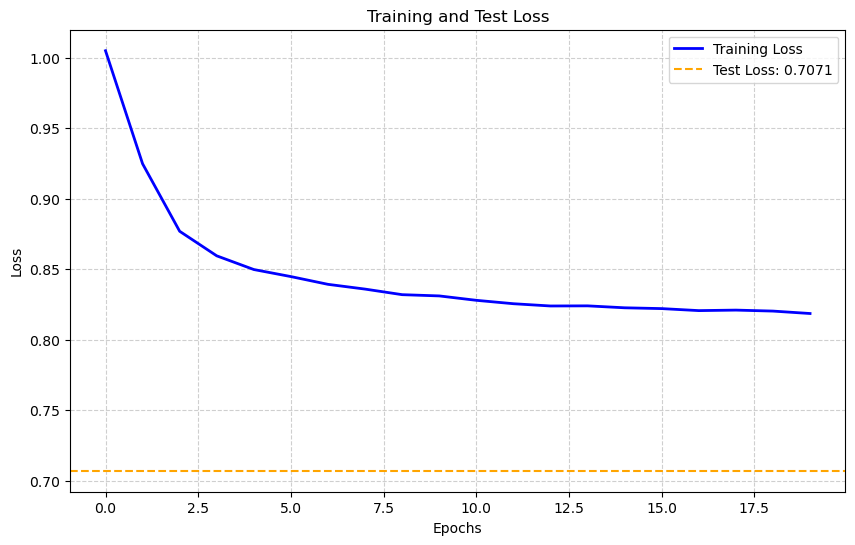

In [ ]:
loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

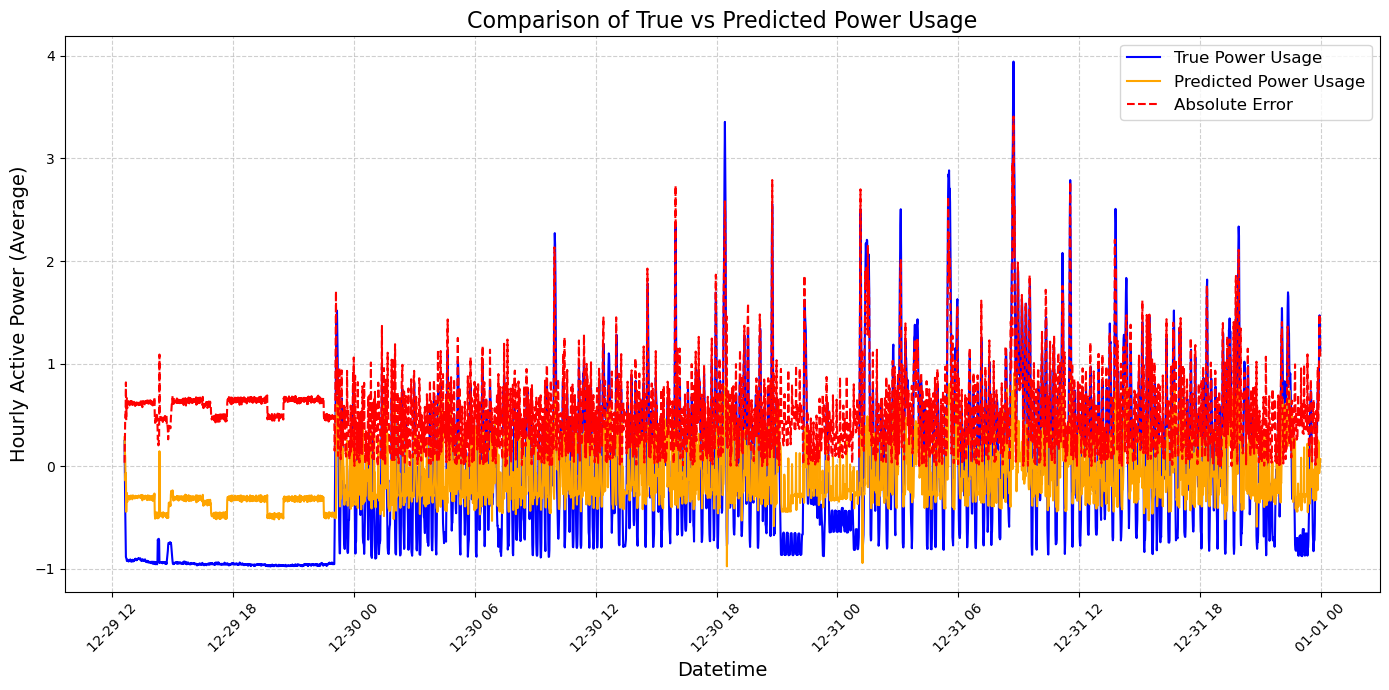

In [ ]:
y_pred_test = model.predict(X_test, verbose=0).squeeze() 
datetime_test = np.array(data['Datetime'][-len(y_test):]) 
y_test = y_test.squeeze()
y_pred_test = y_pred_test.squeeze() 

y_test_df = pd.DataFrame(y_test, columns=[f'True_{i}' for i in range(5)])
y_pred_test_df = pd.DataFrame(y_pred_test, columns=[f'Predicted_{i}' for i in range(5)])

y_test_df['True_Avg'] = y_test_df.mean(axis=1) 
y_pred_test_df['Predicted_Avg'] = y_pred_test_df.mean(axis=1) 

datetime_test = np.array(data['Datetime'][-len(y_test):])

results = pd.DataFrame({
    'Datetime': datetime_test,  
    'True_Avg': y_test_df['True_Avg'], 
    'Predicted_Avg': y_pred_test_df['Predicted_Avg'] 
})

results['Absolute_Error'] = np.abs(results['True_Avg'] - results['Predicted_Avg'])

plt.figure(figsize=(14, 7))
plt.plot(results['Datetime'], results['True_Avg'], label='True Power Usage', color='blue', linewidth=1.5)
plt.plot(results['Datetime'], results['Predicted_Avg'], label='Predicted Power Usage', color='orange', linewidth=1.5)
plt.plot(results['Datetime'], results['Absolute_Error'], label='Absolute Error', color='red', linestyle='--', linewidth=1.5)

plt.legend(fontsize=12, loc='upper right')
plt.title('Comparison of True vs Predicted Power Usage', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power (Average)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
print(f"Min prediction: {y_pred_test.min()}")
print(f"Max prediction: {y_pred_test.max()}")
print(f"Mean prediction: {y_pred_test.mean()}")

Min prediction: -1.245763897895813
Max prediction: 2.2885122299194336
Mean prediction: -0.10777593404054642
